### extract icesat-2 measurements corresponding to swot data.

In [69]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import seaborn as sns
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.neighbors import BallTree
from utils.swot_utils import IQR_filter
from utils.atl13_readout import read_atl13
from matplotlib.ticker import MultipleLocator


In [70]:
## dianchi
path_atl13_dianchi = 'data/isat2/dianchi/ATL13_20240503191439_07052301_007_01.h5'
path_lake_dianchi = 'data/lakes-vec/dianchi_s2_20240415.gpkg'
### erhai
path_atl13_erhai = 'data/isat2/erhai/ATL13_20241113052615_08852501_007_01.h5'
path_lake_erhai = 'data/lakes-vec/erhai_s2_20240801.gpkg'


In [71]:
lake_dianchi_gdf = gpd.read_file(path_lake_dianchi)
lake_erhai_gdf = gpd.read_file(path_lake_erhai)

## inner buffer the lake polygon
def buffer_lake_polygon(lake_vec_wgs84, buffer_m=-500):
    lake_vec_shrink = lake_vec_wgs84.copy()
    lon_center = lake_vec_shrink.bounds.mean(axis=1).values
    utm_zone = np.floor(lon_center/6)+31
    epsg_code = f'326{int(utm_zone[0])}'
    lake_vec_shrink = lake_vec_shrink.to_crs(epsg=epsg_code)
    lake_vec_shrink['geometry'] = lake_vec_shrink.geometry.buffer(buffer_m)
    lake_vec_shrink = lake_vec_shrink.to_crs(epsg=4326)
    return lake_vec_shrink

lake_buffer_dianchi = buffer_lake_polygon(lake_dianchi_gdf, buffer_m=-500)
lake_buffer_erhai = buffer_lake_polygon(lake_erhai_gdf, buffer_m=-500)


In [72]:
print(path_atl13_erhai)
!h5ls $path_atl13_erhai/gt1l


data/isat2/erhai/ATL13_20241113052615_08852501_007_01.h5
alpha_mle                Dataset {112398/Inf}
anom_ssegs               Group
atl13refid               Dataset {112398/Inf}
bottom_lat               Dataset {112398/Inf}
bottom_lon               Dataset {112398/Inf}
cloud_flag_asr_atl09     Dataset {112398/Inf}
cloud_flag_atm_atl09     Dataset {112398/Inf}
cycle_number             Dataset {112398/Inf}
delta_time               Dataset {112398/Inf}
err_ht_water_surf        Dataset {112398/Inf}
err_slope_trk            Dataset {112398/Inf}
ht_ortho                 Dataset {112398/Inf}
ht_water_surf            Dataset {112398/Inf}
ice_flag                 Dataset {112398/Inf}
inland_water_body_id     Dataset {112398/Inf}
inland_water_body_region Dataset {112398/Inf}
inland_water_body_size   Dataset {112398/Inf}
inland_water_body_source Dataset {112398/Inf}
inland_water_body_type   Dataset {112398/Inf}
layer_flag_atl09         Dataset {112398/Inf}
met_ts_atl09             Dataset {1123

### 1. read and mask atl13 data

In [73]:
## dianchi
atl13_dianchi = xr.open_dataset(path_atl13_dianchi, group='gt1r')
vars_atl13_dianchi = {'lat':atl13_dianchi['segment_lat'].values, 
                      'lon':atl13_dianchi['segment_lon'].values, 
                      'h':atl13_dianchi['ht_ortho'].values}
## erhai
atl13_erhai = xr.open_dataset(path_atl13_erhai, group='gt3l')
vars_atl13_erhai = {'lat':atl13_erhai['segment_lat'].values, 
                      'lon':atl13_erhai['segment_lon'].values, 
                      'h':atl13_erhai['ht_ortho'].values}
vars_atl13_erhai


{'lat': array([  2.25241017,   2.25350957,   2.25467616, ..., -72.81527228,
        -72.81522267, -72.81511326]),
 'lon': array([  0.20710805,   0.20704397,   0.20698275, ..., -82.74915544,
        -82.74917951, -82.74923309]),
 'h': array([-0.06756224,  0.03609918, -0.16096708, ..., -1.7273765 ,
        -1.6953254 , -1.643072  ], dtype=float32)}

In [74]:
extent_dianchi = [lake_dianchi_gdf.bounds.minx[0]-0.1, lake_dianchi_gdf.bounds.maxx[0]+0.1, 
          lake_dianchi_gdf.bounds.miny[0]-0.1, lake_dianchi_gdf.bounds.maxy[0]+0.1]
extent_erhai = [lake_erhai_gdf.bounds.minx[0]-0.1, lake_erhai_gdf.bounds.maxx[0]+0.1, 
          lake_erhai_gdf.bounds.miny[0]-0.1, lake_erhai_gdf.bounds.maxy[0]+0.1]


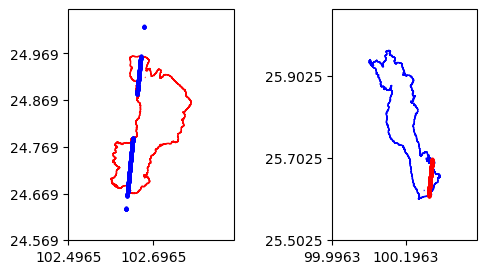

In [75]:
## check the atl13 data
fig, ax = plt.subplots(1,2, figsize=(6, 3), 
                    subplot_kw={'projection': ccrs.PlateCarree()}   )
## dianchi
ax[0].set_extent(extent_dianchi, crs=ccrs.PlateCarree())
lake_dianchi_gdf.plot(ax=ax[0], facecolor="none", edgecolor='red')
ax[0].scatter(x=vars_atl13_dianchi['lon'], y=vars_atl13_dianchi['lat'], 
              c='blue', s=3.5)
ax[0].set_xticks(np.arange(extent_dianchi[0], extent_dianchi[1], 0.2))
ax[0].set_yticks(np.arange(extent_dianchi[2], extent_dianchi[3], 0.1))

## erhai
ax[1].set_extent(extent_erhai, crs=ccrs.PlateCarree())
lake_erhai_gdf.plot(ax=ax[1], facecolor="none", edgecolor='blue')
ax[1].scatter(x=vars_atl13_erhai['lon'], y=vars_atl13_erhai['lat'], c='red', s=3.5)
ax[1].set_xticks(np.arange(extent_erhai[0], extent_erhai[1], 0.2));
ax[1].set_yticks(np.arange(extent_erhai[2], extent_erhai[3], 0.2));


### 2. mask the measurement outside the lake and calculate lake height

In [76]:
### remove the measurement outside the lake
def vars_mask(vars_in, lake_gdf):
    vars_masked = vars_in.copy()
    ids_lake = np.zeros(shape=(vars_in['lon'].shape))
    for i, lon in enumerate(vars_in['lon']):
        point = Point(lon, vars_in['lat'][i])
        if lake_gdf.geometry[0].contains(point):
            ids_lake[i]=1
    for key in vars_in.keys():
        vars_masked[key] = vars_in[key][ids_lake==1]
    return vars_masked
## dianchi
vars_atl13_masked_dianchi = vars_mask(vars_in=vars_atl13_dianchi, lake_gdf=lake_buffer_dianchi)
print(vars_atl13_masked_dianchi['h'].shape) 
## erhai
vars_atl13_masked_erhai = vars_mask(vars_in=vars_atl13_erhai, lake_gdf=lake_buffer_erhai)
print(vars_atl13_masked_erhai['h'].shape) 


(261,)
(135,)


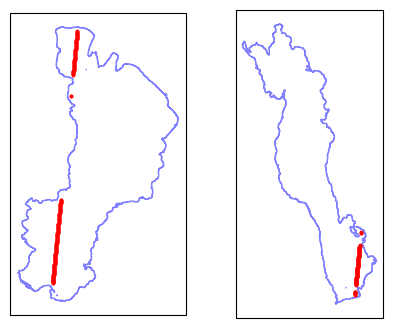

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(5, 4), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
lake_dianchi_gdf.plot(ax=ax[0], facecolor="None", edgecolor='blue', linewidth=1, alpha=0.5)
ax[0].scatter(x=vars_atl13_masked_dianchi['lon'], 
              y=vars_atl13_masked_dianchi['lat'], 
              # c=vars_atl13_masked_dianchi['h'], 
              c='red',
              s=3)
lake_erhai_gdf.plot(ax=ax[1], facecolor="None", edgecolor='blue', linewidth=1, alpha=0.5)
ax[1].scatter(x=vars_atl13_masked_erhai['lon'], 
              y=vars_atl13_masked_erhai['lat'], 
              # c=vars_atl13_masked_erhai['h'], 
              c='red',
              s=3)


#### 2. read and geophysical correcting the swot data

In [78]:
path_swot_dianchi = 'data/swot_l2/pixc/dianchi-lake/SWOT_L2_HR_PIXC_014_396_111R_20240501T141945_20240501T141956_PIC0_01_readout.nc'
path_swot_erhai = 'data/swot_l2/pixc/erhai-lake/SWOT_L2_HR_PIXC_024_077_199L_20241114T203341_20241114T203352_PIC2_01_readout.nc'
pixc_dianchi_xr = xr.open_dataset(path_swot_dianchi)
pixc_erhai_xr = xr.open_dataset(path_swot_erhai)
pixc_dianchi_xr


<xarray.Dataset> Size: 22MB
Dimensions:           (points: 415155)
Coordinates:
    latitude          (points) float64 3MB ...
    longitude         (points) float64 3MB ...
Dimensions without coordinates: points
Data variables:
    height            (points) float32 2MB ...
    solid_earth_tide  (points) float32 2MB ...
    pole_tide         (points) float32 2MB ...
    load_tide_fes     (points) float32 2MB ...
    iono_cor_gim_ka   (points) float32 2MB ...
    geoid             (points) float32 2MB ...
    pixel_area        (points) float32 2MB ...
    geolocation_qual  (points) float64 3MB ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3282
    interferogram_size_range:    5110
    looks_to_efflooks:           1.5533118527618814
    num_azimuth_looks:           7.0
    azimuth_offset:              7

In [79]:
def height_cor(pixc_nc):
    """geophysical corrections for the height data.
       ! no inverse barometric correction.
    """
    height = pixc_nc.height.values
    solid_tide = pixc_nc.solid_earth_tide.values
    pole_tide = pixc_nc.pole_tide.values
    load_tide = pixc_nc.load_tide_fes.values
    iono_corr = pixc_nc.iono_cor_gim_ka.values  ## LakeSP product not have this correction.
    geoid = pixc_nc.geoid.values
    return height - (solid_tide + pole_tide + load_tide + iono_corr)-geoid    

ht_cor_dianchi = height_cor(pixc_nc=pixc_dianchi_xr)  ## egm2008 height
ht_cor_erhai = height_cor(pixc_nc=pixc_erhai_xr)


In [80]:
### outlier filter
def pixc_filter(ht):
    ht_IQR, IQR = IQR_filter(ht)
    iter = 0
    while IQR > 0.4:    
        iter += 1
        ht_IQR_mask = ht_IQR.mask
        ht_IQR, IQR = IQR_filter(ht_IQR.filled(np.nan))
        ht_IQR.mask = ht_IQR.mask | ht_IQR_mask
        if iter == 10: break     ## max iteration: 4 times.
    return ht_IQR

ht_IQR_dianchi, IQR_dianchi = IQR_filter(ht_cor_dianchi)
pixc_filtered_dianchi = {'lon':pixc_dianchi_xr.longitude[~ht_IQR_dianchi.mask], 
                            'lat':pixc_dianchi_xr.latitude[~ht_IQR_dianchi.mask], 
                            'ht':ht_IQR_dianchi[~ht_IQR_dianchi.mask]}

ht_IQR_erhai, IQR_erhai = IQR_filter(ht_cor_erhai)
pixc_filtered_erhai = {'lon':pixc_erhai_xr.longitude[~ht_IQR_erhai.mask], 
                            'lat':pixc_erhai_xr.latitude[~ht_IQR_erhai.mask], 
                            'ht':ht_IQR_erhai[~ht_IQR_erhai.mask]}

print(IQR_dianchi)


0.221435546875


Text(0.5, 1.0, 'dianchi')

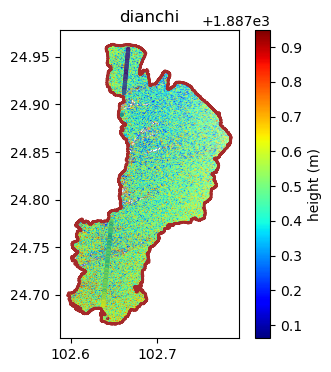

In [81]:
## dianchi
fig, ax = plt.subplots(figsize=(4,4))
scat = ax.scatter(x=pixc_filtered_dianchi['lon'], y=pixc_filtered_dianchi['lat'], 
                    c=pixc_filtered_dianchi['ht'], s=0.1, 
                    edgecolor='none', cmap='jet')
ax.scatter(x=vars_atl13_masked_dianchi['lon'], y=vars_atl13_masked_dianchi['lat'], 
                    c=vars_atl13_masked_dianchi['h'], s=3.5)
lake_dianchi_gdf.plot(ax=ax, edgecolor='Brown', 
                      facecolor='none', linewidth=2)
fig.colorbar(scat).set_label('height (m)')
ax.set_title('dianchi')


Text(0.5, 1.0, 'erhai')

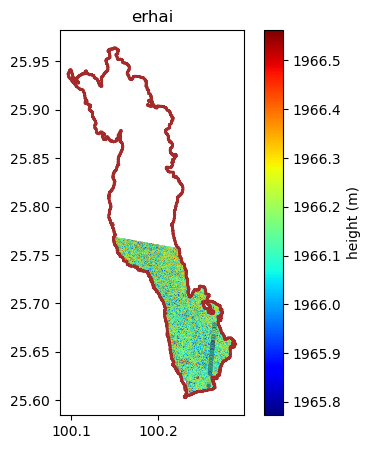

In [82]:
### erhai
fig, ax = plt.subplots(figsize=(5,5))
scat = ax.scatter(x=pixc_filtered_erhai['lon'], 
                  y=pixc_filtered_erhai['lat'], 
                  c=pixc_filtered_erhai['ht'], 
                  s=0.1, 
                  edgecolor='none', 
                  cmap='jet')
ax.scatter(x=vars_atl13_masked_erhai['lon'], y=vars_atl13_masked_erhai['lat'], 
           c=vars_atl13_masked_erhai['h'], s=3.5)
lake_erhai_gdf.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)
fig.colorbar(scat).set_label('height (m)')
ax.set_title('erhai')


#### 3. find the swot pixels which nearest to the atl13 points.

In [83]:
## dianchi
atl13_lon_dianchi, atl13_lat_dianchi = vars_atl13_masked_dianchi['lon'], vars_atl13_masked_dianchi['lat']
lon_pixc_dianchi, lat_pixc_dianchi = pixc_filtered_dianchi['lon'], pixc_filtered_dianchi['lat']
points_atl13_dianchi = np.stack((atl13_lon_dianchi, atl13_lat_dianchi), axis=1)
points_pixc_dianchi = np.stack((lon_pixc_dianchi, lat_pixc_dianchi), axis=1)
## erhai
atl13_lon_erhai, atl13_lat_erhai = vars_atl13_masked_erhai['lon'], vars_atl13_masked_erhai['lat']
lon_pixc_erhai, lat_pixc_erhai = pixc_filtered_erhai['lon'], pixc_filtered_erhai['lat']
points_atl13_erhai = np.stack((atl13_lon_erhai, atl13_lat_erhai), axis=1)
points_pixc_erhai = np.stack((lon_pixc_erhai, lat_pixc_erhai), axis=1)


In [84]:
def find_nearest_points_balltree(points_ref, points_target):
    """
    使用BallTree进行高效最近邻搜索
    """
    rad_ref = np.radians(points_ref)
    rad_target = np.radians(points_target)
    tree = BallTree(rad_target, metric='haversine')
    # 查询最近邻
    distances_rad, indices = tree.query(rad_ref, k=1)
    distances = distances_rad * 6371000
    # 展平结果数组
    indices, distances = indices.flatten(), distances.flatten()
    return indices, distances   

indices_dianchi, distances_dianchi = find_nearest_points_balltree(points_ref=points_atl13_dianchi, 
                                                  points_target=points_pixc_dianchi)
indices_erhai, distances_erhai = find_nearest_points_balltree(points_ref=points_atl13_erhai, 
                                                  points_target=points_pixc_erhai)


In [85]:
ht_pixc_target_dianchi = pixc_filtered_dianchi['ht'][indices_dianchi]
ht_pixc_target_erhai = pixc_filtered_erhai['ht'][indices_erhai] 
ht_pixc_target_erhai.shape


(135,)

In [86]:
pixc_atl13_dianchi = {'atl13':vars_atl13_masked_dianchi['h'],
                      'pixc':ht_pixc_target_dianchi}
pixc_atl13_dianchi_df = pd.DataFrame(pixc_atl13_dianchi)
pixc_atl13_erhai = {'atl13':vars_atl13_masked_erhai['h'],
                    'pixc':pixc_filtered_erhai['ht'][indices_erhai]}
pixc_atl13_erhai_df = pd.DataFrame(pixc_atl13_erhai)
pixc_atl13_dianchi_df


,atl13,pixc
0,1887.281738,1887.457886
1,1887.294312,1887.637207
2,1887.283569,1887.430786
3,1887.297119,1887.412964
4,1887.311523,1887.148804
...,...,...
256,1887.482422,1887.381592
257,1887.513550,1887.632812
258,1887.497192,1887.457275
259,1887.509277,1887.423950


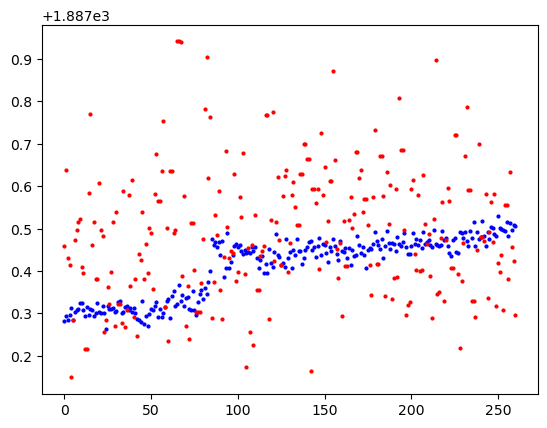

In [87]:
plt.plot(pixc_atl13_dianchi_df['atl13'], 'o', color='blue', markersize=2)
plt.plot(pixc_atl13_dianchi_df['pixc'], 'o', color='red', markersize=2)


In [88]:
print(pixc_atl13_dianchi_df['atl13'].mean())
print(pixc_atl13_dianchi_df['pixc'].mean())
print(pixc_atl13_dianchi_df['atl13'].std())
print(pixc_atl13_dianchi_df['pixc'].std())


1887.4116
1887.4922
0.07276777178049088
0.15199077129364014


Text(0.5, 0, 'Orthometric Height (m)')

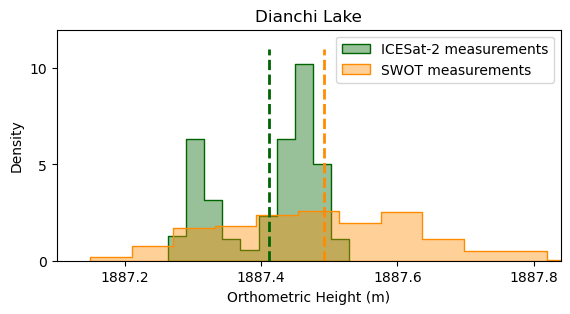

In [91]:
fig, ax = plt.subplots(1,1, figsize=(6.5, 3))
sns.histplot(pixc_atl13_dianchi_df, x="atl13", color="DarkGreen",
             element="step", stat="density", label="ICESat-2 measurements", alpha=0.4)
sns.histplot(pixc_atl13_dianchi_df, x="pixc", color="DarkOrange",
             element="step", stat="density", label="SWOT measurements", alpha=0.4)
ax.vlines(pixc_atl13_dianchi_df['atl13'].mean(), 0, 11,
            colors='DarkGreen', linestyles='--', linewidth=2)
ax.vlines(pixc_atl13_dianchi_df['pixc'].mean(), 0, 11, 
            colors='DarkOrange', linestyles='--', linewidth=2)
ax.set_xlim(1887.1, 1887.84); ax.set_ylim(0, 12)
ax.ticklabel_format(style='plain', axis='x', useOffset=False)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.legend()
ax.set_title('Dianchi Lake')
ax.set_xlabel('Orthometric Height (m)')

In [92]:
print(pixc_atl13_erhai_df['atl13'].mean())
print(pixc_atl13_erhai_df['pixc'].mean())
print(pixc_atl13_erhai_df['atl13'].std())
print(pixc_atl13_erhai_df['pixc'].std())


1965.9745
1966.1482
0.023770740255713463
0.10453689098358154


Text(0.5, 0, 'Orthometric Height (m)')

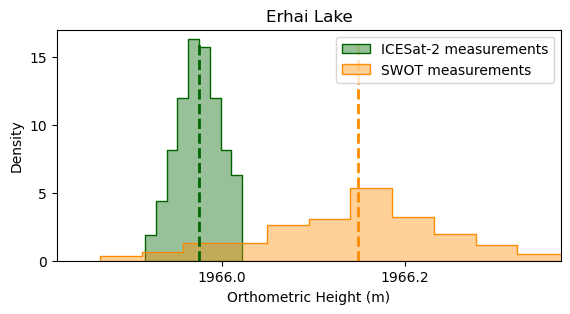

In [117]:
fig, ax = plt.subplots(1,1, figsize=(6.5, 3))
sns.histplot(pixc_atl13_erhai_df, x="atl13", color="DarkGreen", 
             element="step", stat="density", label="ICESat-2 measurements", alpha=0.4)
sns.histplot(pixc_atl13_erhai_df, x="pixc", color="DarkOrange", 
             element="step", stat="density", label="SWOT measurements", alpha=0.4)
ax.vlines(pixc_atl13_erhai_df['atl13'].mean(), 0, 16,
            colors='DarkGreen', linestyles='--', linewidth=2)
ax.vlines(pixc_atl13_erhai_df['pixc'].mean(), 0, 16, 
            colors='DarkOrange', linestyles='--', linewidth=2)
ax.set_xlim(1965.82, 1966.37)
ax.set_ylim(0, 17)
ax.ticklabel_format(style='plain', axis='x', useOffset=False)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.legend()
ax.set_title('Erhai Lake')
ax.set_xlabel('Orthometric Height (m)')